In [2]:
import pandas as pd
import os


In [3]:
full_em = pd.read_csv('data/andbrainDataSet108.csv')

In [4]:
data = pd.read_csv('data/russia_201901_1_tweets_csv_hashed.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
full_em.head()

,word,disgust,surprise,neutral,anger,sad,happy,fear
0,Abuse,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099
1,Aggravate,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099
2,Agitate,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099
3,Agony,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099
4,Annoy,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099


In [6]:
full_em['word'] = full_em['word'].apply(lambda x: (x[:-1]).lower())

In [7]:
full_em.head(), len(full_em)

(        word   disgust  surprise   neutral     anger       sad     happy  \
 0      abuse  0.001099  0.001099  0.001099  0.141758  0.001099  0.001099   
 1  aggravate  0.001099  0.001099  0.001099  0.141758  0.001099  0.001099   
 2    agitate  0.001099  0.001099  0.001099  0.141758  0.001099  0.001099   
 3      agony  0.001099  0.001099  0.001099  0.141758  0.001099  0.001099   
 4      annoy  0.001099  0.001099  0.001099  0.141758  0.001099  0.001099   
 
        fear  
 0  0.001099  
 1  0.001099  
 2  0.001099  
 3  0.001099  
 4  0.001099  , 23729)

In [8]:
# I am making 2 toy subset Data Frames and 2 subsets Pandas Series 

### Retweets
retweets_mask = data['is_retweet'] == True
retweets = data[retweets_mask]
toy_retweets_text = retweets['tweet_text'][:100 ]
toy_retweets_df = retweets[:100]


# Tweets
tweets_mask = data['is_retweet'] == False
tweets = data[tweets_mask]
toy_tweets_df = tweets[:100]
toy_tweets_text = tweets['tweet_text'][:100]


#English Only
tweets_english = tweets[ tweets['account_language'] == 'en']
retweets_english = retweets[ retweets['account_language'] == 'en']


In [9]:
### Creating a function to clean_up the twitter_text
#### ALL WORKS!!!!
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#Additional
import string
string.punctuation

# In this edit I didn't remove # and @ hoping to find the way to remove it together with the followings
punct = set(string.punctuation)
punct.remove('@')
punct.remove('#')
punct.add('🇺🇸')
punct.add('🤢')

lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

import preprocessor as p
import re

def preprocessing_text(text):
    '''
    INPUT: str
    OUTPUT: str w/ emojies, urls, hashtags and mentions removed
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER)
    clean_text = p.clean(text)
    
    return clean_text

def remove_symbols(word, symbol_set):
    
    '''
    Removing symbols from word
    '''
    return ''.join(char for char in word 
                    if char not in symbol_set)


def clean_tweet_text(text_column):
    '''
    takes a columns in dataframe with tweets text: 
    Outputs: PD Series of tokenized docs
    lower case, 
    symbol_set charachters removed
    punctuation removed
    words stemmed and lemmatized
    
    '''
    
    
    # converting from pd to list
    corpus = text_column.values.tolist()
    
    #Removing all HTTPs
    docs_no_http = [ re.sub(r'https?:\/\/.*\/\w*', '', doc) for doc in corpus ]
    #First ---> tokenize docs
    tokenized_docs = [doc.split() for doc in docs_no_http]
    # Lower case words in doc
    tokenized_docs_lowered  = [[word.lower() for word in doc]
                                for doc in tokenized_docs]

    # Removing punctuation from docs
    cleaned_docs = [[remove_symbols(word, punct) for word in doc] 
                    for doc in tokenized_docs_lowered]

    ### Removing stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    docs_no_stops = [[word for word in doc if word not in stop_words] 
                     for doc in cleaned_docs]
    # Lemmatize words in docs
    docs_lemmatized = [[lemmer.lemmatize(word) for word in doc]
                      for doc in docs_no_stops]
    
    # Stem words in docs
    docs_stemmed = [[stemmer.stem(word) for word in doc]
                      for doc in docs_lemmatized]
    
    # Removes mentions, emotions, hashtags and emojies
    docs_no_mentions = [preprocessing_text(' '.join(doc)) for doc in docs_stemmed]
    
    bag = []
    for doc in docs_no_mentions:
        if len(doc) >= 2:
            bag.append(doc)
    
    # converts into list of lists
    bow = [list(tweet.split(' ')) for tweet in bag]
    
    
    # convert docs into pd series
    full_service_docs_series = pd.Series( (v[0] for v in bow) )
    
    return bag, bow, docs_stemmed, full_service_docs_series



bag, bow, docs_stemmed, full_service_docs_series = clean_tweet_text(tweets['tweet_text'])
# docs_stemmed[:3], bag[:3], bow[:3], full_service_docs_series[:3]

In [10]:
tweet_full_bag_english, tweet_full_bow_english, tweet_full_docs_stemmed_english, tweet_english_full_service_doc_series = clean_tweet_text(tweets_english['tweet_text'])

In [11]:
from collections import Counter

def get_em_words_freq(bow, words_list):
    words_freq = Counter()
    for tweet in bow:
        for word in tweet:
            if word in words_list:
                words_freq[word]  += 1
    return(words_freq)  



def get_words(data, n = 1104):
    '''
    Input Emotions pd DataFrame, 
          n -- INT, slise size
    OUTPUT list of words of length n
    '''
    em_data = pd.read_csv('data/Andbrain_DataSet4.csv')
    em_data['word'] = em_data['word'].apply(lambda x: x[:-1])
    word = em_data['word'].tolist()
    words_list = word[:n]
    return words_list

In [12]:
words_list = get_words('data/andbrainDataSet108.csv', n = 23729) 

In [13]:
words_freq = get_em_words_freq(tweet_full_bow_english, words_list)

In [14]:
df = pd.DataFrame.from_dict(words_freq, orient = 'index')

In [15]:
df.head()

,0
face,521
fact,698
korea,252
nuclear,325
huge,131


In [16]:
df.reset_index(inplace = True)



In [17]:
df.columns = ['word', 'counts']

In [18]:
df.head()

,word,counts
0,face,521
1,fact,698
2,korea,252
3,nuclear,325
4,huge,131


In [19]:
em_model = pd.merge(full_em, df, how= 'left', on='word')

In [20]:
em_model.sample(2)

,word,disgust,surprise,neutral,anger,sad,happy,fear,counts
21813,twinkle,0.023810,0.023810,0.023810,0.023810,0.071429,0.071429,0.023810,NaN
947,ann,0.011905,0.083333,0.011905,0.011905,0.011905,0.035714,0.035714,36.0


In [21]:
em_model = em_model.fillna(0)

In [22]:
len(em_model)

23729

In [23]:
em_model.head()

,word,disgust,surprise,neutral,anger,sad,happy,fear,counts
0,abuse,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099,0.0
1,aggravate,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099,0.0
2,agitate,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099,0.0
3,agony,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099,0.0
4,annoy,0.001099,0.001099,0.001099,0.141758,0.001099,0.001099,0.001099,0.0


In [24]:
em_model['total_disgust'] = (em_model['disgust'])*(em_model['counts'])
em_model['total_surprise'] = (em_model['surprise'])*(em_model['counts'])
em_model['total_neutral'] = (em_model['neutral'])*(em_model['counts'])
em_model['total_anger'] = (em_model['anger'])*(em_model['counts'])
em_model['total_sad'] = (em_model['sad'])*(em_model['counts'])
em_model['total_happy'] = (em_model['happy'])*(em_model['counts'])
em_model['total_fear'] = (em_model['fear'])*(em_model['counts'])


In [25]:
sum_disgust = sum(em_model['total_disgust']) 
sum_surprise = sum(em_model['total_surprise']) 
sum_neutral = sum(em_model['total_neutral']) 
sum_anger = sum(em_model['total_anger']) 
sum_sad = sum(em_model['total_sad']) 
sum_happy = sum(em_model['total_happy']) 
sum_fear = sum(em_model['total_fear']) 

totals = sum_disgust+sum_surprise+sum_neutral+sum_sad+sum_happy+sum_fear
weighted_totals = [sum_disgust/totals, sum_surprise/totals, sum_neutral/totals, sum_anger/totals, sum_sad/totals, sum_happy/totals, sum_fear/totals ]

In [26]:
totals, weighted_totals

(8589.357172536827,
 [0.049466012095051685,
  0.21055161635788527,
  0.03602274730816502,
  0.21807698452087396,
  0.18027000035675714,
  0.25655708262597016,
  0.26713254125617075])

In [27]:
emotions_total = [sum_disgust, sum_surprise, sum_neutral, sum_anger, sum_sad, sum_happy, sum_fear]

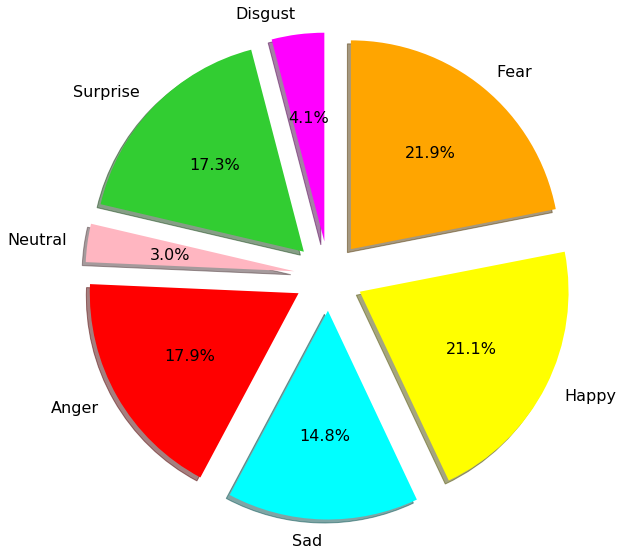

In [33]:
import matplotlib.pyplot as plt
emotions = ['Disgust', 'Surprise', 'Neutral', 'Anger', 'Sad', 'Happy', 'Fear'] 
  
# portion covered by each label 
slices = weighted_totals
  
# color for each label 
colors = ['Fuchsia', 'limegreen', 'lightpink', 'red', 'cyan', 'yellow', 'orange' ] 
  
# plotting the pie chart 
plt.figure(figsize=(8, 8))
plt.pie(slices, labels = emotions, colors=colors,  
        startangle=90, shadow = True, explode = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2), 
        radius = 1.2, autopct = '%1.1f%%', textprops={'fontsize': 16}) 
  

# plt.title('Emotion Composition. Tweets Corpus.')
plt.savefig('plots/pie_emotion.png')
plt.show() 

In [29]:
d = {'Emotions': ['Disgust', 'Surprise', 'Neutral', 'Anger', 'Sad', 'Happy', 'Fear'], 'Total': weighted_totals}
em_counts = pd.DataFrame(data=d)

In [30]:
em_counts.head()

,Emotions,Total
0,Disgust,0.049466
1,Surprise,0.210552
2,Neutral,0.036023
3,Anger,0.218077
4,Sad,0.180270


In [31]:
em_counts.Total.values

array([0.04946601, 0.21055162, 0.03602275, 0.21807698, 0.18027   ,
       0.25655708, 0.26713254])

Text(0.5, 0, '% Detected')

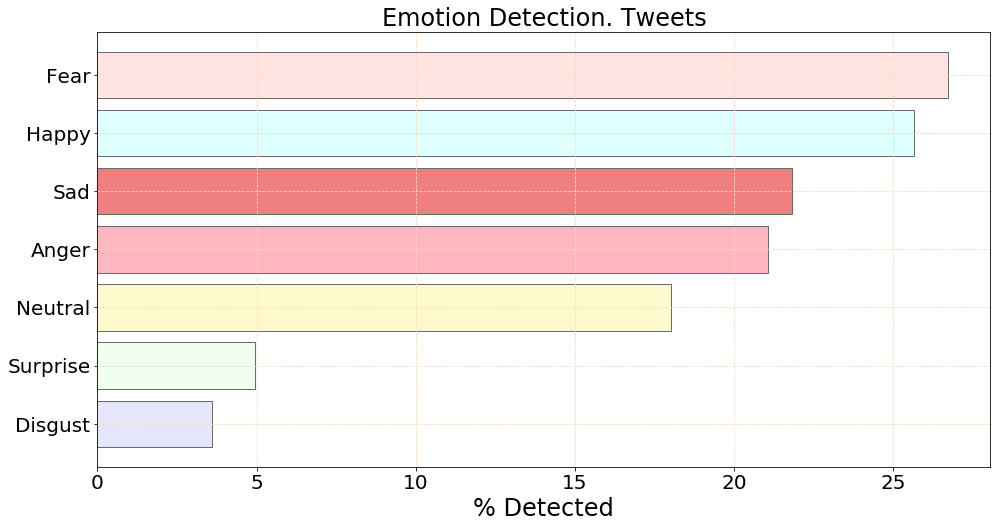

In [32]:
import seaborn as sns
plt.figure(figsize=(16, 8))

ax = plt.barh(y = [0,1,2,3,4,5,6], width = sorted(em_counts.Total.values*100), 
              tick_label = em_counts.Emotions, 
              color = ['Lavender', 'Honeydew', 'Lemonchiffon', 'Lightpink', 'Lightcoral', 'LightCyan', 'MistyRose' ], 
              edgecolor='dimgrey')
plt.grid(c = 'peachpuff', linestyle = '--')

plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Emotion Detection. Tweets', fontsize = 24)
plt.xlabel('% Detected', fontsize = 24)